# # Model Evaluation and Interpretation

In [10]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway, chi2_contingency
import pymysql
pymysql.install_as_MySQLdb()
import sys
import os

# # Load and preprocess data

In [11]:
# Add project path
sys.path.append(os.path.abspath(".."))

# Import database connection module
from database.db_connection import DatabaseConnector

# Handle database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit on connection failure

# Load data from the database
try:
    forecast_df = pd.read_sql("SELECT * FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT * FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data from the database: {e}")
    sys.exit(1)  # Exit on data loading failure

# Extract month from datetime
weather_df['month'] = pd.to_datetime(weather_df['datetime']).dt.month

# Filter out months with insufficient data for ANOVA
month_counts = weather_df['month'].value_counts()
valid_months = month_counts[month_counts > 1].index
weather_df = weather_df[weather_df['month'].isin(valid_months)]

# Define features and target
X = weather_df[['month', 'relative_humidity_2m', 'wind_speed_10m']]
y = weather_df['temperature_2m']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Evaluate models

In [12]:
# Initialize models
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print("=== Linear Regression ===")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"R²: {r2_linear:.2f}")

print("\n=== Random Forest Regressor ===")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

=== Linear Regression ===
Mean Squared Error (MSE): 3.65
R²: 0.33

=== Random Forest Regressor ===
Mean Squared Error (MSE): 3.91
R²: 0.28


# # Significance tests

In [13]:
# ANOVA: Test for differences in temperature across months
if len(valid_months) > 1:
    anova_result = f_oneway(
        *[weather_df[weather_df['month'] == month]['temperature_2m'] for month in valid_months]
    )
    print("\n=== ANOVA ===")
    print(f"F-statistic: {anova_result.statistic:.2f}")
    print(f"p-value: {anova_result.pvalue:.4f}")
else:
    print("\nANOVA could not be performed due to insufficient data across months.")

# Chi-squared test: Association between month and high/low humidity
weather_df['high_humidity'] = (weather_df['relative_humidity_2m'] > 75).astype(int)
chi2_table = pd.crosstab(weather_df['month'], weather_df['high_humidity'])

if chi2_table.shape[0] > 1 and chi2_table.shape[1] > 1 and not chi2_table.isnull().values.any():
    chi2_result = chi2_contingency(chi2_table)
    print("\n=== Chi-squared Test ===")
    print(f"Chi2 statistic: {chi2_result[0]:.2f}")
    print(f"p-value: {chi2_result[1]:.4f}")
    print(f"Degrees of freedom: {chi2_result[2]}")
    print("Expected frequencies:")
    print(pd.DataFrame(chi2_result[3], index=chi2_table.index, columns=chi2_table.columns))
else:
    print("\nChi-squared test could not be performed due to insufficient data.")


ANOVA could not be performed due to insufficient data across months.

Chi-squared test could not be performed due to insufficient data.


# # Interpretation

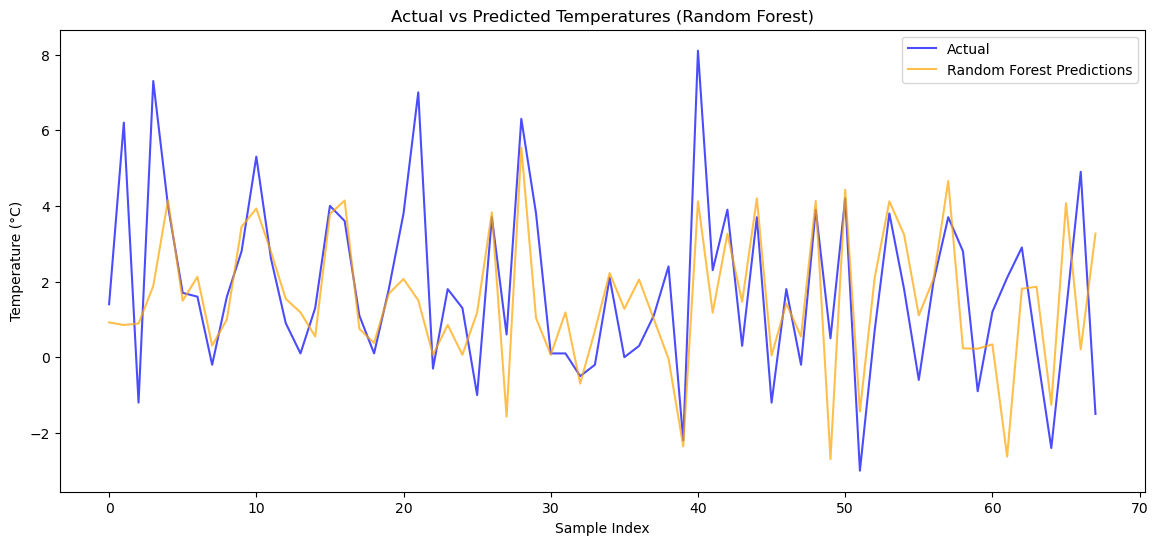

Model evaluation and significance testing completed.


In [14]:
# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_rf, label='Random Forest Predictions', color='orange', alpha=0.7)
plt.title("Actual vs Predicted Temperatures (Random Forest)")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

print("Model evaluation and significance testing completed.")